## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 

<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

# Detección de sarcasmo
Para este ejercicio vas a utilizar el dataset del paper [A Large Self-Annotated Corpus for Sarcasm](https://arxiv.org/abs/1704.05579), con un millón de comentarios de Reddit, etiquetados como sarcásticos o no sarcásticos. Se pide:
1. Si hubiese missings, eliminalos


In [67]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [68]:
df = pd.read_csv('./prof/train-balanced-sarcasm1.csv')
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

### Primera exploración

In [69]:
df.tail()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...
1010825,1,"values, as in capitalism .. there is good mone...",frogking,politics,2,2,0,2009-01,2009-01-24 06:20:14,Why do the people who make our laws seem unabl...


1. **label (etiqueta)**:
   - Esta columna es la etiqueta que indica si un comentario es sarcástico o no. 

2. **comment (comentario)**:
   - Esta columna contiene el texto del comentario.

3. **author (autor)**:
   - Indica el autor del comentario.

4. **subreddit**:
   - Es el subreddit de origen del comentario. Los subreddits son comunidades dentro de Reddit dedicados a diferentes temas o intereses.

5. **score (puntuación)**:
   - Es la puntuación total del comentario, que generalmente se basa en el número de votos que recibe. En Reddit, los usuarios pueden votar positivamente (upvote) o negativamente (downvote) un comentario.

6. **ups (votos positivos)**:
   - Indica el número de votos positivos (upvotes) que recibió el comentario.

7. **downs (votos negativos)**:
   - Indica el número de votos negativos (downvotes) que recibió el comentario.

8. **date (fecha)**:
   - Es la fecha de creación del comentario.

9. **created_utc (fecha y hora en formato UTC)**:
   - Esta columna almacena la fecha y hora de creación del comentario en formato UTC (Tiempo Universal Coordinado), que es un estándar de tiempo comúnmente utilizado en sistemas informáticos.

10. **parent_comment (comentario padre)**:
   - Si el comentario es parte de una conversación o hilo de comentarios, esta columna puede contener el texto del comentario padre al que responde. En Reddit, los comentarios pueden estar anidados dentro de hilos de discusión, y el comentario padre es el comentario al que responde el comentario actual.

In [70]:
df.shape

(1010826, 10)

In [71]:
df.describe()

,label,score,ups,downs
count,1010826.0,1.010826e+06,1.010826e+06,1.010826e+06
mean,0.5,6.885676e+00,5.498885e+00,-1.458629e-01
std,0.5,4.834288e+01,4.127297e+01,3.529689e-01
min,0.0,-5.070000e+02,-5.070000e+02,-1.000000e+00
25%,0.0,1.000000e+00,0.000000e+00,0.000000e+00
50%,0.5,2.000000e+00,1.000000e+00,0.000000e+00
75%,1.0,4.000000e+00,3.000000e+00,0.000000e+00
max,1.0,9.070000e+03,5.163000e+03,0.000000e+00


In [72]:
df.describe(include='object')

,comment,author,subreddit,date,created_utc,parent_comment
count,1010771,1010826,1010826,1010826,1010826,1010826
unique,962293,256561,14878,96,1004689,984286
top,You forgot the,Biffingston,AskReddit,2016-12,2016-04-08 05:34:23,me irl
freq,1451,845,65677,53292,6,257


In [73]:
df.isna().sum()

label              0
comment           55
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [74]:
df.duplicated().sum()

28

**¿Cómo se encuentran nuestros datos?**

*Podemos notar que la columna **comment** presenta nulos que debemos de tratar así mismo como los duplicados. Poseemos 1_000_000 de datos apróximadamente, por lo que borrar dichos valores nuloos no nos afectarán.* 

**¿Por qué eliminamos los duplicados?**

*Los duplicados deberán de ser eliminados, ya que, sería redundante trabajar sobre un mismo dato previamente tratado.*

#### Limpieza

In [75]:
df[df.duplicated(keep=False)]

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
851,1,Said the under 2k post karma guy *expert*,iam4real,youdontsurf,1,-1,-1,2016-11,2016-11-02 10:09:10,This subreddit really does suck.
23777,1,Said the under 2k post karma guy *expert*,iam4real,youdontsurf,1,-1,-1,2016-11,2016-11-02 10:09:10,This subreddit really does suck.
66727,1,"USE REAL WORDS, DAMN IT",FlameSpartan,TumblrInAction,1,1,0,2016-09,2016-09-07 00:31:39,"Yo, that's such a kawai'i level of desu, it ma..."
78313,1,"USE REAL WORDS, DAMN IT",FlameSpartan,TumblrInAction,1,1,0,2016-09,2016-09-07 00:31:39,"Yo, that's such a kawai'i level of desu, it ma..."
125805,1,Hey you're that one guy who racked in all that...,OG_Phx_Son,pcmasterrace,1,-1,-1,2016-10,2016-10-02 15:56:40,Practice mowing lawns pls
160906,1,Hey you're that one guy who racked in all that...,OG_Phx_Son,pcmasterrace,1,-1,-1,2016-10,2016-10-02 15:56:40,Practice mowing lawns pls
185564,1,Well this sub went from 64k to 94k last week s...,TheSergeantWinter,battlefield_one,1,-1,-1,2016-10,2016-10-31 12:05:49,"Define ""a lot"", and then tell me how you can j..."
190948,1,"Because Sandy Hook, CT and Aurora, CO were so ...",Gogomelo,news,-9,-9,0,2016-07,2016-07-31 11:59:53,"Just stay out of ghetto neighborhoods, violent..."
198234,1,Unless your neighbour's face is hidden under a...,deadcat,australia,1,1,0,2016-07,2016-07-04 21:45:37,It's much easier to blindly hate a faceless id...
201633,1,"Because Sandy Hook, CT and Aurora, CO were so ...",Gogomelo,news,-9,-9,0,2016-07,2016-07-31 11:59:53,"Just stay out of ghetto neighborhoods, violent..."


*Podemos establecer que la coincidencia en la marca de tiempo *created_utc* es probablemente un error al subir el comentario, ya que ambos se registran en el mismo momento. Esto es común, a veces, debido a acciones como un doble clic accidental, un triple clic o incluso un error en nuestra base de datos. Como mencionamos en la primera revisión, la mejor opción es eliminar este duplicado y conservar uno de los dos o tres registros idénticos.*

In [76]:
df.drop_duplicates(keep='first', inplace=True) # keep='first' tomará el primer comentario que aparezca y eliminará los próximos duplicados que dicha fila posea.

In [77]:
df[df.comment.isna()]

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
602,0,NaN,Tornado_Hunter24,Infinitewarfare,3,-1,-1,2016-11,2016-11-24 01:39:02,Any recommendations?
56269,1,NaN,SodokuIRL,leagueoflegends,1,1,0,2016-09,2016-09-28 08:23:04,"LPL shitshow, EU LCS shitshow. What isn't a sh..."
68590,1,NaN,TossTheDog,westchesterpa,1,-1,-1,2016-10,2016-10-11 20:25:52,Car fires smell delicious to you? You should p...
135348,0,NaN,So12rovv,R6STeams,1,-1,-1,2016-12,2016-12-22 17:24:05,Will do. EU or NA?
199910,0,NaN,Khvostov_7g-02,tf2,1,1,0,2016-05,2016-05-16 05:46:43,"woah, thanks."
258718,1,NaN,PeaceLovePositivity,vaporents,5,5,0,2016-06,2016-06-22 20:37:11,"No, doing drugs while forming a fetus (your ki..."
284331,0,NaN,FieldDay,ar15,1,1,0,2016-05,2016-05-20 22:18:51,"Fuck you too, buddy."
312969,0,NaN,dont_wear_a_C,nameaserver,1,1,0,2016-08,2016-08-05 07:36:37,Thu 2016-08-04 accessing vault............unlo...
328775,1,NaN,wedontlikespaces,todayilearned,6,6,0,2016-08,2016-08-18 12:36:21,What symbol denotes suck?
331735,1,NaN,atlacatl,soccer,1,1,0,2016-06,2016-06-14 13:38:04,Doesn't matter if that experience is garbage


*Nuestro análisis se basa en el contenido de los comentario de la columna "comment" para determinar si son sarcásticos o no, por ende es esencial que utilice los comentarios mismos y no los comentarios padres. En este caso, mantendremos la columna de "comment" intacta y no reemplazararemos los valores **NaN** en ella con los comentarios padres.*

*Los comentarios padres podrían ser útiles para contextualizar o comprender mejor los comentarios individuales, pero para este análisis específico del sarcasmo necesitamos centrarnos en el contenido de los comentarios directamente.*

In [78]:
df.dropna(inplace=True)

*Algunas columnas no presentan un aporte significativo a nuestra clasificación y análisis exploratorio, como por ejemplo las columnas "date", "created_utc" y "author".*

In [79]:
df = df[['label', 'comment','subreddit', 'score', 'ups', 'downs', 'parent_comment']]

In [80]:
pd.set_option('display.max_columns', None)
df['comment'].head(15)

0                                            NC and NH.
1     You do know west teams play against west teams...
2     They were underdogs earlier today, but since G...
3     This meme isn't funny none of the "new york ni...
4                       I could use one of those tools.
5     I don't pay attention to her, but as long as s...
6         Trick or treating in general is just weird...
7                       Blade Mastery+Masamune or GTFO!
8     You don't have to, you have a good build, buy ...
9                     I would love to see him at lolla.
10    I think a significant amount would be against ...
11                       Damn I was hoping God was real
12                                 They have an agenda.
13                                          Great idea!
14    Ayy bb wassup, it makes a bit more sense in co...
Name: comment, dtype: object

### Análisis exploratorio de datos

In [81]:
from utils.funciones import CategoricalAnalysis

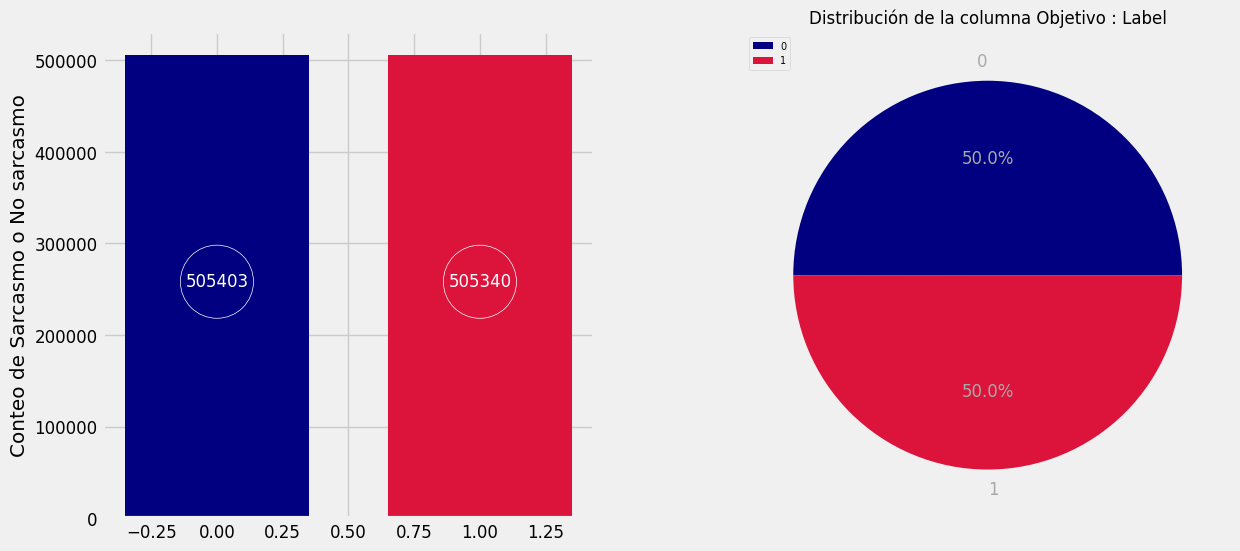

In [82]:
data_distribution = CategoricalAnalysis(df)
data_distribution.plot_top_categories(title='Distribución de la columna Objetivo : Label', column_name='label', labely='Conteo de Sarcasmo o No sarcasmo')

*Confirmamos que nuestra columna objetivo se encuentra balanceada por lo que no será un problema a la hora de predecir nuestros comentarios sarcásticos.* 

*Buscamos lograr un equilibrio en los datos, evitando así la predicción perfecta que ocurre al agregar más ceros en una columna desbalanceada. Nuestro objetivo es que el modelo identifique patrones y realice clasificaciones precisas independientemente de la cantidad de cada clase presente en los datos.*

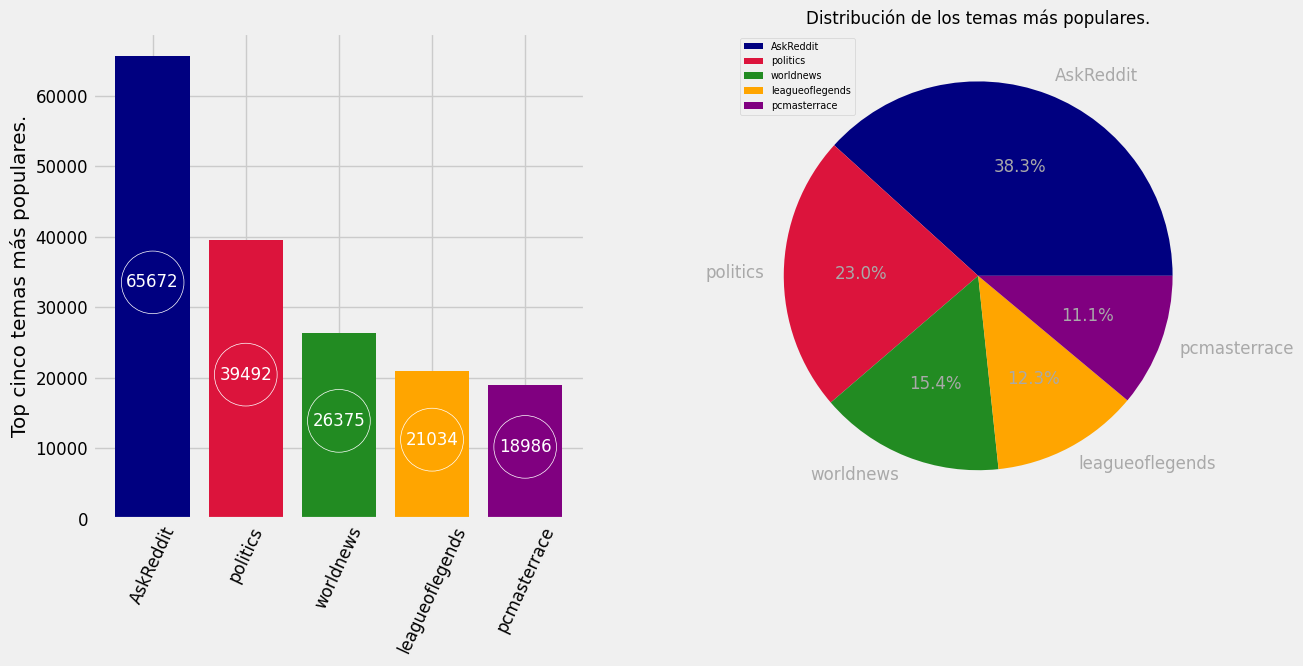

In [83]:
data_distribution.plot_top_categories(title='Distribución de los temas más populares.', column_name='subreddit', labely='Top cinco temas más populares.')

- *"AskReddit" es un subreddit donde los usuarios publican preguntas sobre diversos temas para que otros respondan.*

- *"World News" es una sección en Reddit donde se comparten noticias globales.*

- *"Politics" se centra específicamente en discusiones políticas de diversos temas.*

- *"League of Legends" es un popular juego en línea desarrollado por Riot Games, donde dos equipos compiten en tiempo real para destruir la base enemiga.*

- *"PC Master Race" es un término usado en la comunidad de videojuegos para describir a quienes prefieren jugar en PC sobre consolas, destacando las ventajas de personalización y gráficos.*

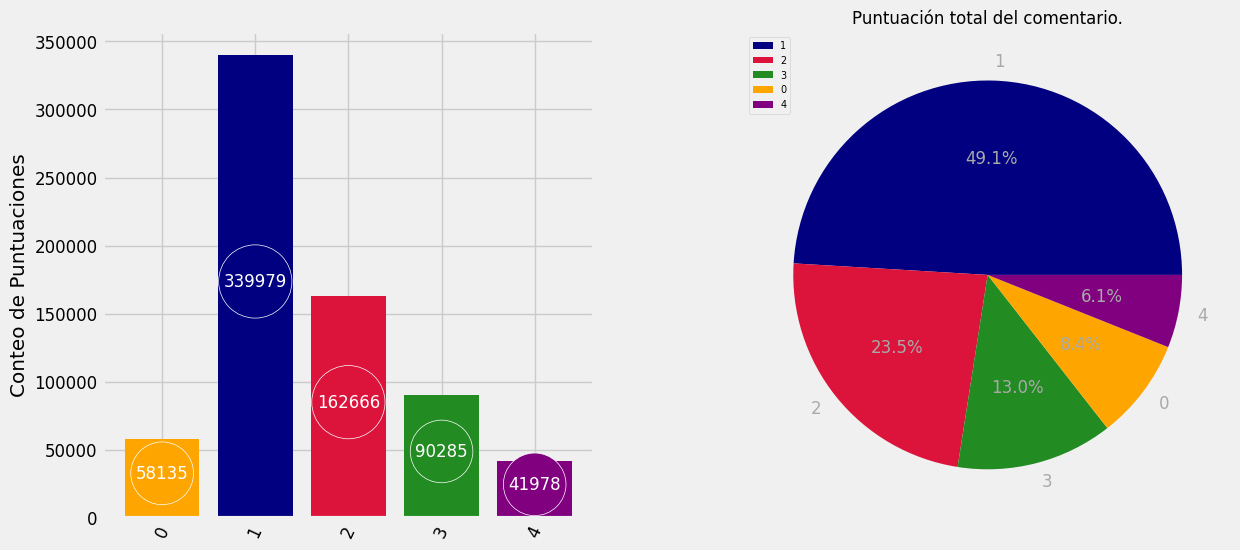

In [84]:
data_distribution.plot_top_categories(title='Puntuación total del comentario.', column_name='score', labely='Conteo de Puntuaciones')

*Como la columna "score" representa el total del comentario, prescindiré de las columnas "ups" y dows" que representan al final si es positivo o negativo*

### 2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).

In [85]:
df.head(2)

,label,comment,subreddit,score,ups,downs,parent_comment
0,0,NC and NH.,politics,2,-1,-1,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,nba,-4,-1,-1,The blazers and Mavericks (The wests 5 and 6 s...


In [86]:
df.shape

(1010743, 7)

In [111]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['subreddit', 'ups', 'downs', 'parent_comment', 'label']), df['label'], test_size=0.2, random_state=24)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(808594, 2)
(202149, 2)
(808594,)
(202149,)


In [102]:
for i in range(5):
    print('####################')
    print(x_train['comment'][i])

####################
NC and NH.
####################
You do know west teams play against west teams more than east teams right?
####################
They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1
####################
This meme isn't funny none of the "new york nigga" ones are.
####################
I could use one of those tools.


In [112]:
from sklearn.preprocessing import MinMaxScaler
# Inicializar y ajustar MinMaxScaler a los datos de entrenamiento
scaler = MinMaxScaler()
scaler.fit(x_train['score'].values.reshape(-1, 1))

# Transformar la columna "score" en los conjuntos de entrenamiento y prueba
score_train_scaled = scaler.transform(x_train['score'].values.reshape(-1, 1))
score_test_scaled = scaler.transform(x_test['score'].values.reshape(-1, 1))

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import eli5
from scipy.sparse import hstack

# Inicializar y ajustar el TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(x_train['comment'])
X_train = tfidf_vectorizer.transform(x_train['comment'])
X_test = tfidf_vectorizer.transform(x_test['comment'])

In [114]:
# Concatenar las características extraídas del texto con la columna "score" escalada
X_train_with_score_scaled = hstack((X_train, score_train_scaled))
X_test_with_score_scaled = hstack((X_test, score_test_scaled))

# Entrenar el modelo Logistic Regression
lr = LogisticRegression()
params = {'C': [0.01, 0.5]}
grid = GridSearchCV(lr, params, cv=5)
grid.fit(X_train_with_score_scaled, y_train)

# Evaluar el modelo en el conjunto de prueba y mostrar la precisión
print("Final Accuracy:", accuracy_score(y_test, grid.best_estimator_.predict(X_test_with_score_scaled)))

Final Accuracy: 0.6940919816570945


************

### 3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)

In [115]:
# Mostrar los pesos de las características utilizando el mejor estimador
eli5.show_weights(grid.best_estimator_)

Weight?,Feature
+6.715,x93535
+6.099,x28513
+5.749,x133168
+5.289,x51430
+5.238,x41497
+4.771,x146603
+4.712,x16925
+4.695,x35093
+4.445,x41897
+4.429,x54710


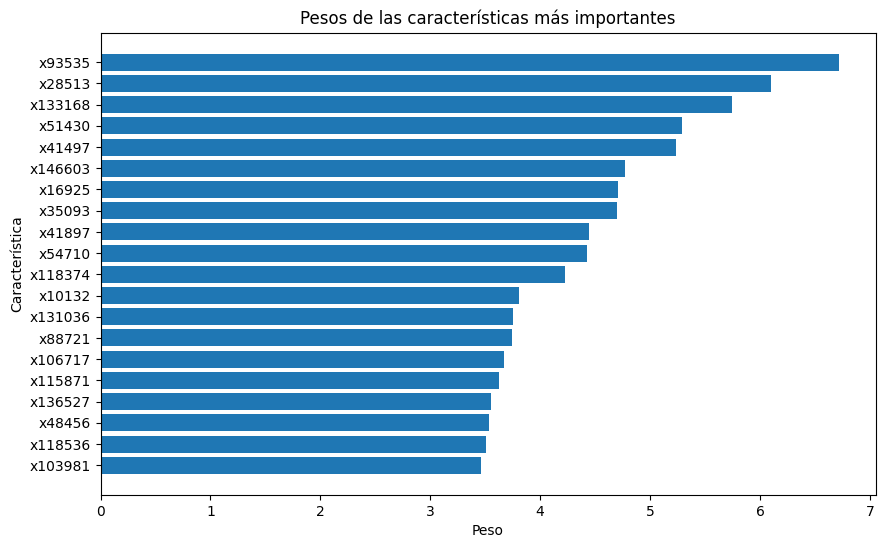

In [116]:
# Obtener los pesos de las características y sus nombres
weights = eli5.explain_weights_df(grid.best_estimator_)
feature_names = weights['feature']

# Limitar el número de características a mostrar en el gráfico de barras
num_features = 20  # Por ejemplo, muestra las 20 características más importantes

# Seleccionar las primeras 'num_features' características y sus pesos
top_features = weights.head(num_features)

# Crear un gráfico de barras para visualizar los pesos de las características
plt.figure(figsize=(10, 6))
plt.barh(range(num_features), top_features['weight'], align='center')
plt.yticks(range(num_features), top_features['feature'])
plt.xlabel('Peso')
plt.ylabel('Característica')
plt.title('Pesos de las características más importantes')
plt.gca().invert_yaxis()  # Invertir el eje y para que las características más importantes estén arriba
plt.show()


*En resumen, `eli5` es una biblioteca de Python que ayuda a entender modelos de aprendizaje automático. Puede visualizar la importancia de características, inspeccionar predicciones individuales, depurar modelos, comparar modelos y es compatible con una variedad de modelos de aprendizaje automático. Es una herramienta valiosa para interpretar y mejorar modelos de manera efectiva.*